# Laboratorio 2

Profesor: Joaquín Fontbona

Auxiliares: Bruno Hernández, Pablo Araya

Grupo: 14

Integrantes: Branco Paineman, Diego Dominguez, Sebastián Rojas

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #sirve para graficar
from scipy.stats import dirichlet,beta,norm,uniform,chi2,bernoulli, poisson, binom, geom
import random as rd
import time
import math
import pandas as pd
from scipy.stats import relfreq

# Pregunta 1


El objetivo de este problema es aproximar mediante algoritmos de Monte Carlo con vaja varianza, el siguiente vaor $\alpha = \mathbb{E}[e^{bZ} 1_{Z>0}]$, con $Z$ una variable normal estándar y $b \in \mathbb{R}$ constante.

Definiendo $f(Z)=e^{bZ} 1_{Z>0}$, se puede realizar la siguiente simulación.


In [ ]:
#Variable Z ~ N(0,1)
#f(Z)=exp(b*Z)*1_{Z>0}

'Input: b real y N la dimensión de la muestra'
'Output: f_Z arreglo correspondiente a f(Z), Z variable usada, b constante usada'
def f(b,N):
    Z = np.random.normal(0,scale=1,size=N)
    f_ = lambda z : math.exp(b*z) if z>0 else 0
    f_Z=np.zeros(N)
    for k in range(N):
        f_Z[k]=f_(Z[k])
    return f_Z,Z,b

In [ ]:
#Test

a=f(2,1000)
print('f(Z) = '+str(a[0][:10]))
print('Z = '+str(a[1][:10]))
print('b = '+str(a[2]))

f(Z) = [ 0.          2.22973115  7.34287096  0.          0.         15.15898336
  0.          2.02541992  0.          0.        ]
Z = [-2.53298568  0.40094051  0.99686495 -0.70582777 -0.86302026  1.35929666
 -0.45008255  0.35288852 -0.66578236 -0.30306404]
b = 2


## 1)

Se quiere calcular $\int f(Z) \mu(dZ)$, con $\mu(dZ)$ la densidad de $Z \sim N(0,1)$.

Tomando la función $\hat{v}(dz)=\frac{1}{\sqrt 2 \pi}e^{bz} e^{-\frac{1}{2}z^2}$, obtenemos que:
$\frac{1}{\sqrt 2 \pi}\int_{-\infty}^{\infty} e^{bz} e^{-\frac{1}{2}z^2}dz = \mathbb{E}[e^{bz}] = e^\frac{b^2}{2}$

Entonces, normalizando $\hat{v}$ se obtiene la siguiente distribución: $v(dx)=\hat{v}(dx)e^\frac{- b^2}{2}$

Luego, $v(dx) = \frac{1}{\sqrt 2 \pi}e^{bx} e^{-\frac{1}{2}x^2}e^\frac{- b^2}{2} = e^{bx-\frac{b^2}{2}} \frac{1}{\sqrt 2 \pi} e^{-\frac{1}{2}x^2} = L(x)\mu(dx) $, con $L(x)=e^{bx-\frac{b^2}{2}}$

Además, notemos que  $v(dx) = e^{bx-\frac{b^2}{2}} \frac{1}{\sqrt 2 \pi} e^{-\frac{1}{2}Z^2} = \frac{1}{\sqrt 2 \pi} e^{-\frac{1}{2}(b^2 - 2bx +x^2)} = \frac{1}{\sqrt 2 \pi} e^{-\frac{1}{2}(b - x)^2} $, esto implica que la variable aleatoria $X \sim N(b,1)$

Como $Z \sim N(0,1) \Longrightarrow b + Z \sim N(b,1) \Longrightarrow X = b + Z$

Por último, por el método de muestro preferencial se tiene que $\alpha = \mathbb{E}[\frac{f(X)}{L(X)}]$, con $X \sim N(b,1)$

In [ ]:
#Muestreo Preferencial (Método 2)

def muestreo_p(F):
    b=F[2]
    Z=F[1] #Normal estandar
    N=len(Z)
    X=b+Z
    f_ = lambda x : math.exp(b*x) if x>0 else 0
    l = lambda x : math.exp(b*x-(b**2)/2)
    f_X=np.zeros(N)
    l_X=np.zeros(N)
    for k in range(N):
        f_X[k]=f_(X[k])
        l_X[k]=l(X[k])

    Estimacion= np.mean(f_X/l_X)
    return Estimacion,f_X,l_X

In [ ]:
#Test
F=f(2,1000)
muestreo_p(F)[0]

7.211718752556316

## 2)

Se propone la siguiente variable de control: $h(Z)=e^{bZ}$, ya que su esperanza es conocida, la cual es $\mathbb{E}[e^{bz}] = e^\frac{b^2}{2}$.

El $c$ optimo a utilizar se calcula de la siguiente manera: $c = \frac{\sum_{k=1}^{q} (f(Z_{k})-\mathbb{E}(f(Z)))(h(Z_{k})-\mathbb{E}(h(Z)))}{\sum_{k=1}^{q} (h(Z_{k})-\mathbb{E}(h(Z)))^2}$, para un $q \approx 100$ pequeño.

Luego, para estimar $\alpha$ se realiza lo siguiente:

$\alpha = \frac{1}{N} \sum_{k=1}^{N} (f(Z_{k})-c(h(Z_{k})-\mathbb{E}(h(Z))))$

In [ ]:
#h(Z)=exp(b*Z)
#E(h(Z))=exp((b^2)/2)

def h(Z,b,N):
    h_ = lambda z : math.exp(b*z)
    h_Z=np.zeros(N)
    for k in range(N):
        h_Z[k]=h_(Z[k])
    return h_Z

In [ ]:
def C_(Y1,Y2,Z,q,b):
    Y_1=Y1[0:q]
    Y_2=Y2
    F_=np.mean(Y_1)
    E_h = math.exp((b**2)/2)
    numerador=0
    denominador=0
    for k in range(q):
        numerador+=(Y_1[k]-F_)*(Y_2[k]-E_h)
        denominador+=(Y_2[k]-E_h)**2
    c_optimo=numerador/denominador
    return c_optimo

In [ ]:
#Variable de Control (Método 3)

def v_control(F,q):
    f_Z=F[0]
    Z=F[1]
    b=F[2]
    N=len(Z)
    h_Z=h(Z,b,N)
    E_h = math.exp((b**2)/2)
    c=C_(f_Z,h_Z,Z,q,b)
    Suma=0
    for k in range(N):
        Suma+=f_Z[k]-c*(h_Z[k]-E_h)
    Estimacion=Suma/N
    return Estimacion

In [ ]:
#Test
F=f(2,1000)
v_control(F,100)

7.190730186505542

## 3)

Tenemos que $Z \sim N(0,1)  $,    $  f(Z)=e^{bZ} 1_{Z>0}  $ y   $  h(Z)=e^{bZ}  $

Se propone la siguiente variable antitetica: $  \bar{f}(Z)=e^{-bZ} 1_{Z<0}  $ y   $  \bar{h}(Z)=e^{-bZ}  $

De tal forma que $\bar{f}(Z) = f(-Z)$ y $ \bar{h}(Z) = h(-Z)$, pues $-Z \sim N(0,1)$

Luego definiendo $Y1=\frac{f(Z)+\bar{f}(Z)}{2}$ y $Y2=\frac{h(Z)+\bar{h}(Z)}{2}$, se puede aproximar $\alpha$ de la siguiente manera:

$\alpha = \frac{1}{N} \sum_{k=1}^{N} (Y1_{k}-c(Y2_{k}-\mathbb{E}(Y2)))$

Con $c = \frac{\sum_{k=1}^{q} (Y1_{k} - \bar{Y1})(Y2_{k} -\mathbb{E}(Y2))}{\sum_{k=1}^{q} (Y2_{k} -\mathbb{E}(Y2))^2}$, para un $q \approx 100$ pequeño.

In [ ]:
def f_ant(Z,b):
    N=len(Z)
    f_ = lambda z : math.exp(-b*z) if z<0 else 0
    f_Z_a=np.zeros(N)
    for k in range(N):
        f_Z_a[k]=f_(Z[k])
    return f_Z_a

def h_ant(Z,b,N):
    h_ = lambda z : math.exp(-b*z)
    h_Z=np.zeros(N)
    for k in range(N):
        h_Z[k]=h_(Z[k])
    return h_Z

In [ ]:
#Variable Antitética (Método 4)

def v_antitetica(F,q):
    f_Z=F[0]
    Z=F[1]
    b=F[2]
    f_Z_=f_ant(Z,b)
    Y1=(f_Z+f_Z_)/2
    N=len(Z)
    h_Z=h(Z,b,N)
    h_Z_=h_ant(Z,b,N)
    Y2=(h_Z+h_Z_)/2
    E_h = math.exp((b**2)/2)
    c=C_(Y1,Y2,Z,q,b)
    Suma=0
    for k in range(N):
        Suma+=Y1[k]-c*(Y2[k]-E_h)
    Estimacion=Suma/N
    return Estimacion

In [ ]:
#Test
F=f(2,1000)
v_antitetica(F,100)

6.944040524070974

## 4)

In [ ]:
# Simulacion de covarianza
def covar(X,Y):
    x_bar=np.mean(X)
    y_bar=np.mean(Y)
    W=(X-x_bar)*(Y-y_bar)
    return sum(W)/(len(X)-1)

#Varianza simulada (Método 1)
def var(X):
    x_bar=np.mean(X)
    Y=(X-x_bar)**2
    return sum(Y)/(len(X)-1)

#Varianza del muestreo preferencial (Método 2)
def var_pref(est,f_x,l_x):
    E1=np.mean(f_x**2/l_x**2)
    E2=est**2
    return E1-E2

#Varianza de Variable de control (Método 3)
def var_control(f_Z,Z,b):
    N=len(Z)
    h_Z=h(Z,b,N)
    varianza_c=var(f_Z)-((covar(f_Z,h_Z)**2)/var(h_Z))
    return varianza_c

#Varianza de Variable Antitética (Método 4)
def var_ant(f_Z,Z,b):
    f_Z_=f_ant(Z,b)
    Y1=(f_Z+f_Z_)/2
    N=len(Z)
    h_Z=h(Z,b,N)
    h_Z_=h_ant(Z,b,N)
    Y2=(h_Z+h_Z_)/2
    varianza_a=var(Y1)-((covar(Y1,Y2)**2)/var(Y2))
    return varianza_a

In [ ]:
#Simulación de la varianza para distintas muestras
b=2
N_=np.array([10,100,1000,10000,100000,250000,500000])
Z_=[]
m=len(N_)
Var=np.zeros(m)
Var_p=np.zeros(m)
Var_c=np.zeros(m)
Var_a=np.zeros(m)

k=0
for N in N_:
    F=f(b,N)
    f_Z=F[0]
    Z=F[1]
    A=muestreo_p(F)
    est=A[0]
    f_X=A[1]
    l_X=A[2]
    Z_.append(Z)
    Var[k]=var(f_Z)
    Var_p[k]=abs(var_pref(est,f_X,l_X))
    Var_c[k]=var_control(f_Z,Z,b)
    Var_a[k]=var_ant(f_Z,Z,b)
    k+=1


In [ ]:
Var1=np.around(Var, decimals=4)
Var1_p=np.around(Var_p, decimals=4)
Var1_c=np.around(Var_c, decimals=4)
Var1_a=np.around(Var_a, decimals=4)

In [ ]:
v=pd.DataFrame([np.append(['Método 1'],[Var1]),np.append(['Método 2'],[Var1_p]),np.append(['Método 3'],[Var1_c]),
                np.append(['Método 4'],[Var1_a])],columns=np.append(['Método'],N_))

v #Tabla de la varianza por cada método según el tamaño de la muestra

,Método,10,100,1000,10000,100000,250000,500000
0,Método 1,29.3335,56.4008,1239.826,2875.719,1891.6025,4249.697,2340.9343
1,Método 2,0.0,1.0701,1.1225,1.2321,1.1946,1.196,1.2212
2,Método 3,0.0909,0.061,0.0668,0.0656,0.0658,0.0657,0.0662
3,Método 4,0.014,0.0134,0.0164,0.0183,0.0185,0.0185,0.0182


Se observa que el método 1 posee una varianza bastante bastante elevada, la cuál crece a medida aumenta el tamaño de la muestra.
Por otro lado, con los métodos de reducción de varianza se consigue reducir significativamente su valor.

El método 2 nos entrega un varianza cercana 1.2, mientras que al utilizar el método 3 y 4 se obtiene una varianza de 0.06 y 0.01 respectivamente.

In [ ]:
#Desviación Estándar = Ráis de la Varianza
Std=np.zeros(m)
Std_p=np.zeros(m)
Std_c=np.zeros(m)
Std_a=np.zeros(m)

for j in range(m):
    Std[j]=math.sqrt(Var[j])
    Std_p[j]=math.sqrt(Var_p[j])
    Std_c[j]=math.sqrt(Var_c[j])
    Std_a[j]=math.sqrt(Var_a[j])

In [ ]:
Std1=np.around(Std, decimals=4)
Std1_p=np.around(Std_p, decimals=4)
Std1_c=np.around(Std_c, decimals=4)
Std1_a=np.around(Std_a, decimals=4)

In [ ]:
s=pd.DataFrame([np.append(['Método 1'],[Std1]),np.append(['Método 2'],[Std1_p]),np.append(['Método 3'],[Std1_c]),
                np.append(['Método 4'],[Std1_a])],columns=np.append(['Método'],N_))

s #Tabla de la desviación estándar por cada método según el tamaño de la muestra

,Método,10,100,1000,10000,100000,250000,500000
0,Método 1,5.416,7.51,35.2112,53.6257,43.4926,65.1897,48.3832
1,Método 2,0.0,1.0345,1.0595,1.11,1.093,1.0936,1.1051
2,Método 3,0.3016,0.2471,0.2585,0.2562,0.2564,0.2563,0.2573
3,Método 4,0.1183,0.1159,0.1281,0.1354,0.1359,0.1361,0.1349


Al observar el comportamiento de la desviación estándar, se puede apreciar mejor que el método 1 entrega una desviación del orden de 40-50. Mientras que el resto de métodos nos entregan un valor mucho más pequeño, cercano a 1.1 para el método 2, a 0.25 para el método 3 y a 0.1 para el método 4.

Se concluye que al mejorar la variable de control usando una variable antitética, se consigue obtener la raíz de la varianza con valor más bajo.

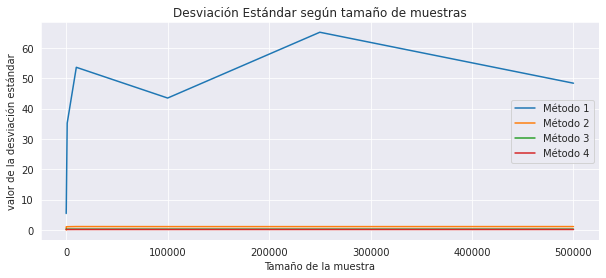

In [ ]:
sns.set_style("darkgrid")
fig, axs = plt.subplots(1, 1, figsize = (10,4))
plt.plot(N_,Std,label='Método 1')
plt.plot(N_,Std_p,label='Método 2')
plt.plot(N_,Std_c,label='Método 3')
plt.plot(N_,Std_a,label='Método 4')
plt.title('Desviación Estándar según tamaño de muestras')
plt.xlabel('Tamaño de la muestra')
plt.ylabel('valor de la desviación estándar')
plt.legend()
plt.show()

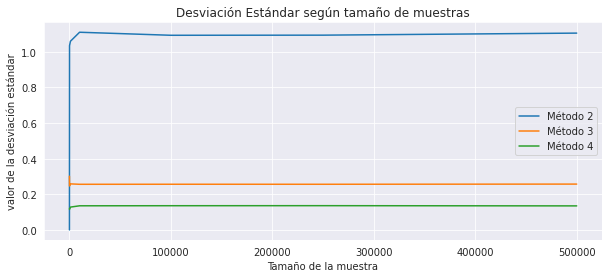

In [ ]:
sns.set_style("darkgrid")
fig, axs = plt.subplots(1, 1, figsize = (10,4))
plt.plot(N_,Std_p,label='Método 2')
plt.plot(N_,Std_c,label='Método 3')
plt.plot(N_,Std_a,label='Método 4')
plt.title('Desviación Estándar según tamaño de muestras')
plt.xlabel('Tamaño de la muestra')
plt.ylabel('valor de la desviación estándar')
plt.legend()
plt.show()

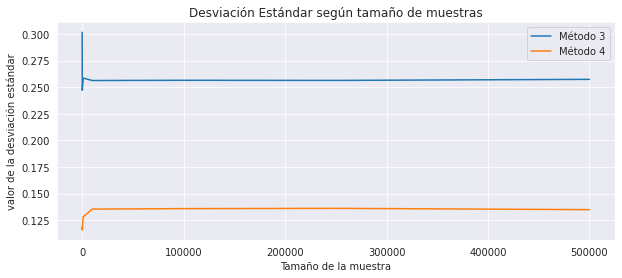

In [ ]:
sns.set_style("darkgrid")
fig, axs = plt.subplots(1, 1, figsize = (10,4))
plt.plot(N_,Std_c,label='Método 3')
plt.plot(N_,Std_a,label='Método 4')
plt.title('Desviación Estándar según tamaño de muestras')
plt.xlabel('Tamaño de la muestra')
plt.ylabel('valor de la desviación estándar')
plt.legend()
plt.show()

In [ ]:
#Estimación de la varianza

var_1=Var[-1]
var_2=Var_p[-1]
var_3=Var_c[-1]
var_4=Var_a[-1]

In [ ]:
ev=pd.DataFrame([['Método 1',var_1],['Método 2',var_2],['Método 3',var_3],['Método 4',var_4]],columns=['Método','Varianza'])

ev

,Método,Varianza
0,Método 1,2340.934291
1,Método 2,1.221249
2,Método 3,0.066213
3,Método 4,0.018205


In [ ]:
#Estimación de la desviación estándar

std_1=Std[-1]
std_2=Std_p[-1]
std_3=Std_c[-1]
std_4=Std_a[-1]

ev=pd.DataFrame([['Método 1',std_1],['Método 2',std_2],['Método 3',std_3],['Método 4',std_4]],columns=['Método','Desviación Estándar'])

ev

,Método,Desviación Estándar
0,Método 1,48.383203
1,Método 2,1.105101
2,Método 3,0.257319
3,Método 4,0.134926


Como conclusión final de esta sección, la varianza y la desviación estándar de los métodos implementados consiguen reducir significativamente el valor de la varianza simulada originalmente, además estos métodos convergen a valores cercanos a uno y cero a mendida que crece el tamaño de la muestra

## 5)

Calcular el tamaño de la muestra $n$ necesario de modo que el $error=0.02$ con probabilidad del 95% ($Z_{\frac{\alpha}{2}}=1.96$)

In [ ]:
n_V_1=(var_1*1.96**2)/0.02**2
n_V_2=(var_2*1.96**2)/0.02**2
n_V_3=(var_3*1.96**2)/0.02**2
n_V_4=(var_4*1.96**2)/0.02**2

In [ ]:
dn=pd.DataFrame([['Método 1',int(n_V_1)],['Método 2',int(n_V_2)],['Método 3',int(n_V_3)],['Método 4',int(n_V_4)]],columns=['Método','N° de réplicas'])

dn

,Método,N° de réplicas
0,Método 1,22482332
1,Método 2,11728
2,Método 3,635
3,Método 4,174


Se puede apreciar que el método 1 necesita muchismas más réplicas que el resto, mientras que el mejor método continua siendo el de variable antitética, la cuál entrega un valor de varianza aceptable con alrededor de 200 réplicas.

El número excesivo de réplicas en los primeros dos métodos se debe a la forma en que fueron implementadas, ya que estos requieren todos los elementos de la muestra para realizar la estimación, mientras que el método 3 y 4 uso de un $q\approx 100$ pequeño para sus cálculos.

## 6)

In [ ]:
#Buscando el n_max
print(int(np.max([n_V_2,n_V_3,n_V_4])))

11728


In [ ]:
#Estimación de la esperanza

n_max=int(np.max([n_V_2,n_V_3,n_V_4]))
rango=np.arange(200,n_max,100)
r=len(rango)

E_1=np.zeros(r+1)
E_2=np.zeros(r+1)
E_3=np.zeros(r+1)
E_4=np.zeros(r+1)
b=2
k=0

for m in rango:
    F=f(b,m)
    E_1[k]=np.mean(F[0])
    E_2[k]=muestreo_p(F)[0]
    E_3[k]=v_control(F,100) #q=100
    E_4[k]=v_antitetica(F,100) #q=100
    k+=1

F=f(b,n_max)
E_1[-1]=np.mean(F[0])
E_2[-1]=muestreo_p(F)[0]
E_3[-1]=v_control(F,100)
E_4[-1]=v_antitetica(F,100)


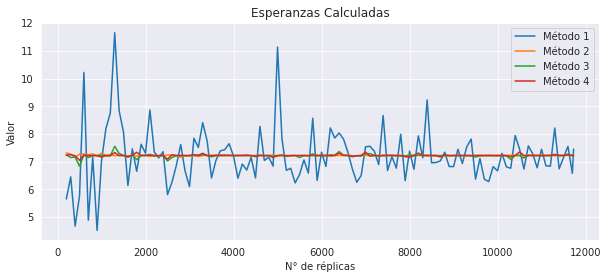

In [ ]:
Rango=np.append(rango,[n_max])

sns.set_style("darkgrid")
fig, axs = plt.subplots(1, 1, figsize = (10,4))
plt.plot(Rango,E_1,label='Método 1')
plt.plot(Rango,E_2,label='Método 2')
plt.plot(Rango,E_3,label='Método 3')
plt.plot(Rango,E_4,label='Método 4')
plt.xlabel('N° de réplicas')
plt.ylabel('Valor')
plt.title('Esperanzas Calculadas')
plt.legend()
plt.show()

En comparación al método 1, el resto de métodos implementados entregan valores de esperanzas similares para la mayoría de número de réplicas.

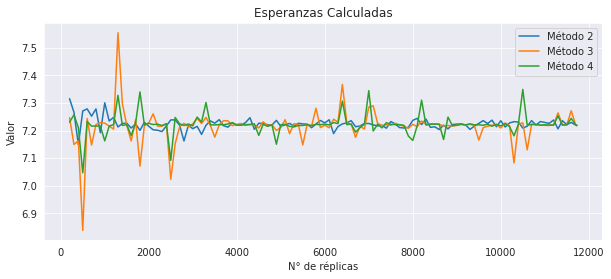

In [ ]:
sns.set_style("darkgrid")
fig, axs = plt.subplots(1, 1, figsize = (10,4))
plt.plot(Rango,E_2,label='Método 2')
plt.plot(Rango,E_3,label='Método 3')
plt.plot(Rango,E_4,label='Método 4')
plt.xlabel('N° de réplicas')
plt.ylabel('Valor')
plt.title('Esperanzas Calculadas')
plt.legend()
plt.show()

A pesar de que el método 4 (Variable antitética) entrega una menor varianza, en la mayoría de los casos el mejor método para obtener el valor de $\alpha$ es el método 2 (Muestreo Preferencial).

In [ ]:
#Estimacion Esperanza

E1=np.around(np.mean(E_1),4)
E2=np.around(np.mean(E_2),4)
E3=np.around(np.mean(E_3),4)
E4=np.around(np.mean(E_4),4)

In [ ]:
es=pd.DataFrame([['Método 1',E1],['Método 2',E2],['Método 3',E3],['Método 4',E4]],columns=['Método','Esperanza'])

es

,Método,Esperanza
0,Método 1,7.2078
1,Método 2,7.2237
2,Método 3,7.2158
3,Método 4,7.2221


Se puede observar que en promedio, todos los métodos entregan valores cercano a 7.2

## 7)

Utilizando WolframAlpha, obtenemos que $\alpha = \mathbb{E}[e^{2Z} 1_{Z>0}] \approx 7.22095  $

In [ ]:
#Estimacion de alpha usando n_max
print('n_max = '+str(n_max))
alpha=7.22095
alpha_1=E_1[-1]
alpha_2=E_2[-1]
alpha_3=E_3[-1]
alpha_4=E_4[-1]

n_max = 11728


In [ ]:
alp=pd.DataFrame([['Método 1',alpha_1],['Método 2',alpha_2],['Método 3',alpha_3],['Método 4',alpha_4]],columns=['Método','Esperanza'])

alp

,Método,Esperanza
0,Método 1,7.451301
1,Método 2,7.217056
2,Método 3,7.220752
3,Método 4,7.218979


In [ ]:
#Diferencias

d_1=abs(alpha-alpha_1)
d_2=abs(alpha-alpha_2)
d_3=abs(alpha-alpha_3)
d_4=abs(alpha-alpha_4)

In [ ]:
dif=pd.DataFrame([['Método 1',d_1],['Método 2',d_2],['Método 3',d_3],['Método 4',d_4]],columns=['Método','Diferencia'])

dif

,Método,Diferencia
0,Método 1,0.230351
1,Método 2,0.003894
2,Método 3,0.000198
3,Método 4,0.001971


De esta tabla se puede concluir que los mejores métodos para $n_{max}$ réplicas es el método 2 y 4, siendo el de Variable Antitética el que mejor aproxima a $\alpha$. Mientras que el método 1 es el que peor aproxima, seguido del método 3.

En base al gráfico anterior, se concluye que el método 4 entrega el mejor valor de $\alpha$ para muestras de tamaño superior a 10.000

## Pregunta 2

El objetivo de esta pregunta es simular una cadena de markov definida de manera recurrente, y luego aplicarla a un paseo aleatoreo acotado.

Se considera $X_{0}$~$\mu$ una v.a y a partir de $(U_{n})_{n\geq0}$ secuencia de uniformes en [0,1] se define $(X_{n})_{n\geq0}$ como sigue:

$X_{n+1}=F(X_{n},U_{n+1})$ donde $F$ es una funcion que toma como parametros estados y elementos en [0,1] y lleva a nuevos estados.

En lo que sigue se demostrara una propiedad de la cadena con una funcion $F$ particular para luego, a partir de esta, programarla.

Supongamos que $\mathbb{E}=\left\lbrace 1,2,3 \ldots N \right\rbrace $ con $N$ algun natural.

Notemos que dado $x,\hat{y} \in \mathbb{E}  $ y $ U([0,1])$ uniforme:

$\left\lbrace Inf\left\lbrace   y\in \mathbb{E}:  \sum_{i=1}^{y}p_{xi}\geq U    \right\rbrace= 	  \hat{y}       \right\rbrace \iff \left\lbrace\forall y<\hat{y}  \sum_{i=1}^{y}p_{xi}< U \land \forall y\geq\hat{y}  \sum_{i=1}^{y}p_{xi}\geq U \right\rbrace \iff \left\lbrace   \sum_{i=1}^{\hat{y}-1} p_{xi}<U\leq \sum_{i=1}^{\hat{y}}p_{xi} \right\rbrace$

Donde la primera equivalencia es por definicion, y la segunda se obtiene acotando.
Asi $ \mathbb{P}(\left\lbrace Inf\left\lbrace   y\in \mathbb{E}:  \sum_{i=1}^{y}p_{xi}\geq U    \right\rbrace= 	  \hat{y}       \right\rbrace)= \mathbb{P}(\left\lbrace   \sum_{i=1}^{\hat{y}-1} p_{xi}<U\leq \sum_{i=1}^{\hat{y}}p_{xi} \right\rbrace )= \sum_{i=1}^{\hat{y}}p_{xi}-\sum_{i=1}^{\hat{y}-1}p_{xi}=p_{x\hat{y}}$

De esta forma $f(x,u):=Inf\left\lbrace   y\in \mathbb{E}:  \sum_{i=1}^{y}p_{xi}\geq u \right\rbrace $ es una funcion de transición y de esta forma la cadena $(X_{n})_{n\geq0}$ definida por recurrencia con funcion $f$ posee matriz de transicion P (la probabilidad de pasar de un estado a otro es exactamente $p_{xy}$ con x e y en el espacio de estados).

### Parte 2:

En esta seccion se programan la funcion $trans(x,u,P)$ y la funcion $CM(\mu,P,n)$, la primera implementa la funcion de transicion de la seccion anterior y la segunda es una cadena de markov de n pasos.En particular se utilizo una forma adecuada de la funcion DiscreteQuantile con el fin de inicializar la cadena.

In [ ]:
def DiscreteQuantile2_0(mu,r):
  j=0
  suma=mu[0]
  while suma<r:
    j+=1
    suma+=mu[j]
  return j


def trans(x,u,P):
  i=0
  Sum_P_xi=P[x][i]
  while Sum_P_xi<u:
    i+=1
    Sum_P_xi+=P[x][i]
  return i

def CM(mu,P,n):

  X=[]
  u=np.random.uniform(0,1)
  X_0=DiscreteQuantile2_0(mu,u)
  X.append(X_0)
  U=np.random.uniform(0,1,n)
  j=0
  while len(X)<n:
    X.append(trans(X[j],U[j+1],P))
    j+=1
  return X

### Parte 3:

En esta seccion se programa la funcion flujo que calcula dado un estado x de la cadena en un tiempo n, el estado sobre el cual se encontrara luego de m paso.

In [ ]:
def flujo(x,n,m,u,P):
  Phi_n0=trans(x,u[0],P)
  Phi_mn=[]
  Phi_mn.append(Phi_n0)
  for j in range(m-n):
    Phi_mn.append(trans(Phi_mn[j],u[j+1],P))
  return Phi_mn[-1]

### Parte 4:
En esta seccion se implementa la matriz estocastica del paseo aleatoreo acotado sobre un vector de estados de tamaño $N$, y probabilidad de salto p, la diferencia con el paseo aleatoreo normal, es que en sus extremos posee probabilidad de salto $p$ y probabilidad $1-p$ de mantenerse.

Ademas se muestran 3 graficos distintos de 3 paseos con probabilidades diferentes de salto, con el fin de observar el comportamiento de la cadena.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def matriz_paseo(N,p):
  P=np.zeros((N,N))
  i=0
  j=0
  while i!=N:
      if j==0:
        P[i,j]=1-p
        P[i,j+1]=p
        i+=1
        j+=1
      elif j==N-1:
        P[i,j]=p
        P[i,j-1]=1-p
        i+=1
      else:
        P[i,j-1]=1-p
        P[i,j+1]=p
        i+=1
        j+=1

  return P




def cadena(n,N,p,K):
  P=matriz_paseo(K,p)
  tiempo=np.arange(0,100)
  for i in range(K):
    mu=np.zeros(K)
    mu[i]=1
    np.random.seed(0)
    Cm=CM(mu,P,n)
    plt.plot(tiempo,Cm)
    plt.xlabel('n')
    plt.ylabel('Estados')
    plt.title('Marcha aleatorea acotada con p='+str(np.around(p,3)))
   # plt.show()


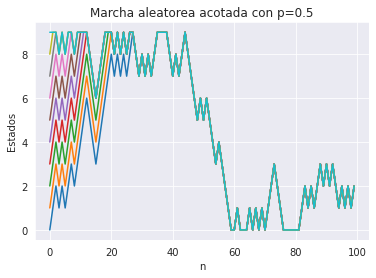

In [ ]:
cadena(100,100,0.5,10)

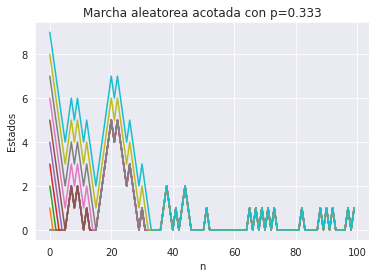

In [ ]:
cadena(100,100,1/3,10)

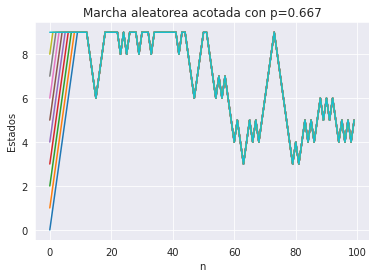

In [ ]:
cadena(100,100,2/3,10)

# Pregunta 3

En esta pregunta se estudiará la aplicación de cadenas de Markov a un modelo de colas, y se estimará la distribución invariante (cuando exista) utilizando simulaciones de la cadena.

El modelo consiste en una cola a tiempo discreto en que para cada tiempo $n\in\mathbb{N}$ llega un cliente con probabilidad $p\in(0,1)$ y siempre que haya al menos un cliente en la cola, un cliente es atendido (y sale de la cola inmediatamente) con probabilidad $q\in(0,1)$.

Sea $X_{n}$ la cantidad de personas en la cola a tiempo $n$, y sean $(Y_{n})_{n\in\mathbb{N}}$ variables Bernoulli de parámetro $p$, $(Z_{n})_{n\in\mathbb{N}}$ variables Bernoulli de parámetro $q$, todas independientes entre sí.

Se puede representar si llega o no una persona en el tiempo $n$ a través de $Y_{n}$, pues con probabilidad $p$ se tiene $Y_{n}=1$ (llega una persona) y con probabilidad $1-p$ $Y_{n}=0$ (no llega una persona). Análogamente, podemos representar que una persona se va de la cola al tiempo $n$ a través de $Z_{n}$. Eso sí, se debe notar que esto es cierto cuando hay al menos una persona en la cola, es decir, $X_{n-1}>0$, por lo que para representar si se va una persona al tiempo $n$ debemos considerar la variable $Z_{n}\mathbb{1}_{X_{n-1}>0}.$ Por último, la cantidad de personas que hay en el tiempo $n$ es la cantidad de personas en el tiempo $n-1$, sumado a la cantidad de personas que llegan en el tiempo $n$ (1 con probabilidad $p$, 0 con probabilidad $1-p$, i.e., $Y_{n}$), y menos la cantidad de personas que se van (si es que se puede) en el tiempo $n$ (0 con probabilidad 1 si no hay personas en la cola, mientras que si hay personas en la cola se va una con probabilidd $q$, y se van 0 con probabilidad $1-q$, i.e., $Z_{n}\mathbb{1}_{X_{n-1}>0}$). Con todo lo anterior, la cadena sigue la dinámica
\
$$X_{n}=X_{n-1}+Y_{n}-Z_{n}\mathbb{1}_{X_{n-1}>0}.$$

Así, podemos expresar $X_{n}=F(X_{n-1},Y_{n},Z_{n})$ (con F de la forma mostrada anteriormente), es decir, $X_{n}$ es una función del estado anterior junto a una innovación aleatoria independiente, por lo que $X:=(X_{n})_{n\in\mathbb{N}}$ es una cadena de Markov homogénea por construcción.

Notamos que por la ecuación de Chapman-Kolmogorov, tenemos que la probabilidad de pasar de 0 personas a $k$ en tiempo $k$ $p_{0,k}^{k}\geq p^{k}\cdot (1-q)^{k}>0$ (pues esta es la probabilidad de una forma de pasar de $0$ a $k$ en $k$ pasos, que consiste en que llega una persona en cada instante y ninguna se va), por lo que tenemos $0\rightarrow k.$ Análogamente, $p_{k,0}^{k}\geq q^{k}\cdot (1-p)^{k}>0$, por lo que $k\rightarrow0$, y así $0\leftrightarrow k$ para todo $k\geq1$, luego como la relación $\leftrightarrow$ es de equivalencia, tenemos que $i\leftrightarrow j$ para todo $i,j\in\mathbb{N},$ y con ello, se tiene que $X$ es irreducible.

Se puede demostrar que para $p>q$ la cadena $X$ diverge c.s., para $p=q$ se tiene que que la medida $(1-p,1,1,...)$ es distribución invariante, mientras que para $p<q$ la medida invariante $\pi$ está dada por $$\pi_{0}=\frac{q-p}{q}, \pi_{x}=\left(\frac{p(1-q)}{q(1-p)}\right)^{x}\frac{q-p}{q(1-q)}$$ para $x\geq1.$

Sabemos que la recurrencia (recurrencia positiva, nula, y transiencia) es propiedad de clase. Como para $p,q\in(0,1)$ tales que $p>q$ la cadena $X$ diverge c.s., entonces el número de visitas a $0$ debe ser finito c.s., luego $i$ es transiente, y como $X$ es irreducible, la cadena es transiente.

Como $X$ es irreducible, la existencia de distribución invariante es equivalente a recurrencia positiva. Así, notamos que para el caso $p=q$, tenemos que existe una medida invariante, pero tiene infinitas coordenadas con masa $1$, por lo que su suma no puede ser finita, luego no puede ser normalizada y con ello, no existe distribución invariante, por lo que $X$ no puede ser recurrente positiva. Ahora, probemos que es recurrente a través del criterio algebraico (se puede, pues $X$ es irreducible). Sea $f$ una función armónica acotada en $\mathbb{N}\setminus{0}$, luego $f(i)=\sum_{j\geq0}p_{i,j}f(j)=p_{i,i-1}f(i-1)+p_{i,i}f(i)+p_{i,i+1}f(i+1)=q(1-p)f(i-1)+(pq+(1-p)(1-q))f(i)+p(1-q)f(i+1)$ para $i\geq1.$ Luego, tenemos que $p(1-q)f(i+1)=(p(1-q)+q(1-p))f(i)-q(1-p)f(i-1)$, y entonces $$f(i+1)-f(i)=\frac{q(1-p)}{p(1-q)}(f(i)-f(i-1))$$ para $i\geq1.$ De acá sale que $$f(i+1)-f(i)=\left(\frac{q(1-p)}{p(1-q)}\right)^{i}(f(1)-f(0)),$$ pero como $p=q$, $\frac{q(1-p)}{p(1-q)}=1$. Así, tenemos que $$f(k+1)-f(1)=\sum_{i=0}^{k}(f(i+1)-f(i))=\sum_{i=0}^{k}1^{i}(f(1)-f(0))=k(f(1)-f(0)),$$ para $k\geq1$, es decir, $$f(k+1)=f(1)+k(f(1)-f(0))$$ para $k\geq1.$ Notamos que si $f(1)-f(0)\neq0$, entonces $f(k)$ tiende o a $\infty$ o a $-\infty$ cuando $k\to\infty,$ pero $f$ es acotada, por lo tanto $f(1)=f(0).$ Luego, $f(k+1)=f(1)+k(f(1)-f(0))=f(1)$ para $k\geq1$, por lo tanto $f$ es constante en $\mathbb{N}.$ Luego, por criterio algebraico de recurrencia, $0$ es recurrente, y luego la cadena $X$ es recurrente. Como vimos, no puede ser recurrente positiva, por lo tanto, cuando $p=q$ se tiene que $X$ es recurrente nula.

Por último, para $p<q$ tenemos que la suma de la medida invariante señalada es $$\frac{q-p}{q}+\sum_{x\geq1}\left(\frac{p(1-q)}{q(1-p)}\right)^{x}\frac{q-p}{q(1-q)}=\frac{q-p}{q}+\frac{q-p}{q(1-q)}\cdot\frac{\frac{p(1-q)}{q(1-p)}}{1-\frac{p(1-q)}{q(1-p)}}$$ $$=\frac{q-p}{q}+\frac{q-p}{q(1-q)}\cdot\frac{p(1-q)}{q-p}=\frac{q-p}{q}+\frac{p}{q}=1,$$\
es decir, tenemos que la medida invariante es en realidad una distribución invariante. Con ello, la cadena $X$ es recurrente positiva.


Para lo que sigue, se estudiará una versión truncada de la cadena mencionada anteriormente, donde se fijará una capacidad máxima $N$ de la cola, y se modificará la dinámica de manera que sólo puede llegar una persona en un instante $n$ si en el instante anterior quedaron menos de $N$ personas.

Así, la dinámica de la nueva cadena queda $$X_{n}=X_{n-1}+Y_{n}\mathbb{1}_{X_{n-1}<N}-Z_{n}\mathbb{1}_{X_{n-1}>0},$$
y la matriz de transición queda: \
$p_{0,0}=1-p$, $p_{0,1}=p$ y $p_{0,i}=0$ para $i=2,...,N$,\
$p_{N,N}=1-q$, $p_{N,N-1}=q$ y $p_{N,i}$ para $i=0,...,N-2$, \
$p_{i,i-1}=q(1-p)$, $p_{i,i}=pq+(1-p)(1-q)$, $p_{i,i+1}=p(1-q)$ y $p_{i,j}=0$ para $i=1,...,N-1$, $j=0,...,i-2,i+2,...,N.$

Claramente, esta nueva cadena sigue siendo irreducible por argumentos análogos a la original.

Teniendo esto, se procedió a simular la cadena $(X_{n})_{n\in\mathbb{N}}$, hasta el instante $n=1000$, para los 3 casos mencionados anteriormente: $p>q$, $p=q$ y $p<q.$

Para ello se definió la función *cola* la cual simula la cadena utilizando la dinámica mencionada a partir de un punto inicial $x_{0}$. Para las simulaciones, se tomaron como puntos iniciales $0$ y $40$.



In [ ]:
n=1000

def cola(n,p,q,N,x0): #partiendo en un punto inicial x0
    X=np.zeros(n+1)
    X[0]=x0
    Y=np.random.binomial(1,p,size=n)
    Z=np.random.binomial(1,q,size=n)
    for i in range(n):
        X[i+1]=X[i]
        if X[i]<N:
            X[i+1]+=Y[i]
        if X[i]>0:
            X[i+1]-=Z[i]
    return X

El primer caso en simularse fue cuando se tiene $p>q$. Para ello, se consideró $p=0.4$ y $q=0.2$. Este caso representa cuando es más probable que lleguen un nuevo cliente a que uno se vaya, por lo que es esperable que el valor de la cadena crezca a lo largo del tiempo. Por ello, se tomó un $N=150$ (para evidenciar el crecimiento).

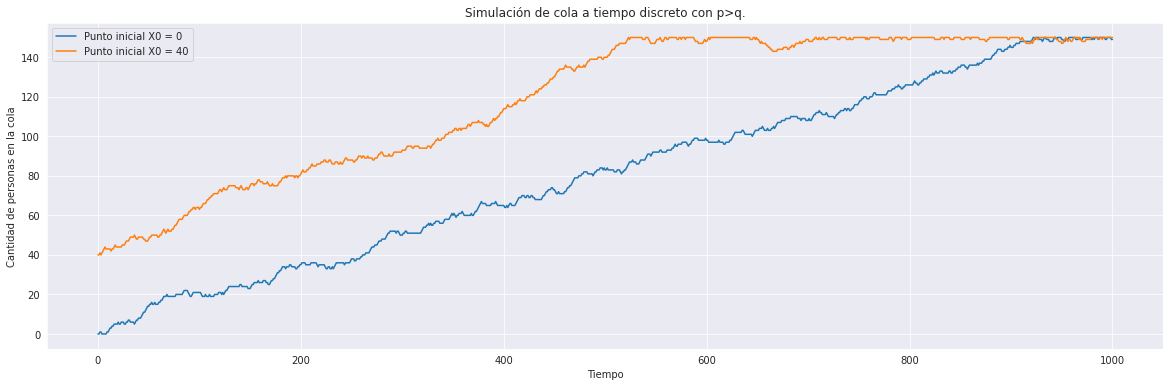

In [ ]:
p1=0.4
q1=0.2
N1=150
plt.figure(figsize=[20,6])
plt.plot(np.arange(0,n+1),cola(n,p1,q1,N1,0),label='Punto inicial X0 = 0')
plt.plot(np.arange(0,n+1),cola(n,p1,q1,N1,40),label='Punto inicial X0 = 40')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de personas en la cola')
plt.title('Simulación de cola a tiempo discreto con p>q.')
plt.legend()

Como era de esperarse, la cadena tiende a crecer independiente del punto de partida, logrando alcanzar en ambos casos la capacidad máxima, y luego oscilando en valores cercanos a él, lo cual, como fue mencionado, se debe a que la probabilidad de que crezca la cadena en un instante ($p$) es mayor a la de que decrezca ($q$).

Luego, se simuló el caso $p=q$. Para este caso se tomó $p=q=0.85$, y un $N=100$, pues es esperable que en este caso la cadena no crezca tanto como en el caso anterior.

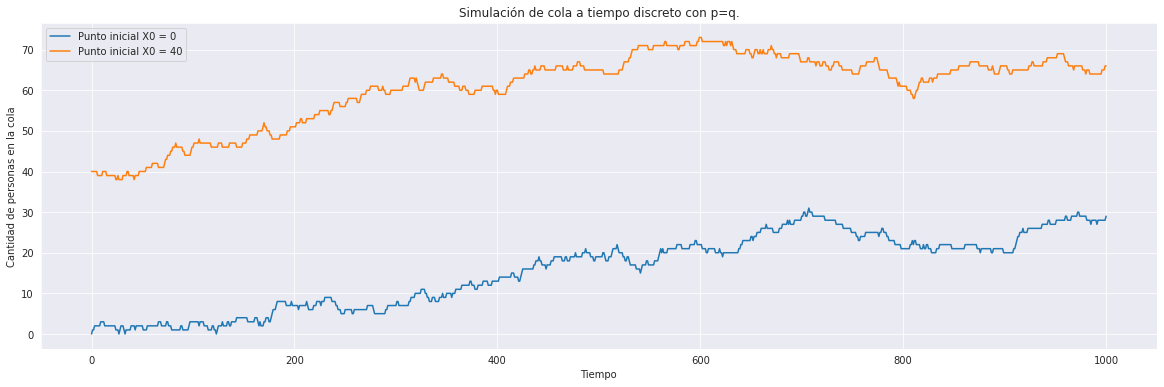

In [ ]:
p2=0.85
q2=0.85
N2=100
plt.figure(figsize=[20,6])
plt.plot(np.arange(0,n+1),cola(n,p2,q2,N2,0),label='Punto inicial X0 = 0')
plt.plot(np.arange(0,n+1),cola(n,p2,q2,N2,40),label='Punto inicial X0 = 40')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de personas en la cola')
plt.title('Simulación de cola a tiempo discreto con p=q.')
plt.legend()

Así, puede observarse que ambas cadenas tienden a ser "estables", en el sentido que no logran crecer ni decrecer en grandes cantidades, sino que tienden a concentrar sus trayectorias en un rango que depende del punto inicial (pero el crecimiento no depende del punto inicial).

Por último, se simuló el caso $p<q$ tomando los valores $p=0.5$ y $q=0.6$, y un $N=60$, pues con lo evidenciado en los dos casos anteriores, es poco probable que la cadena logre valores grandes.

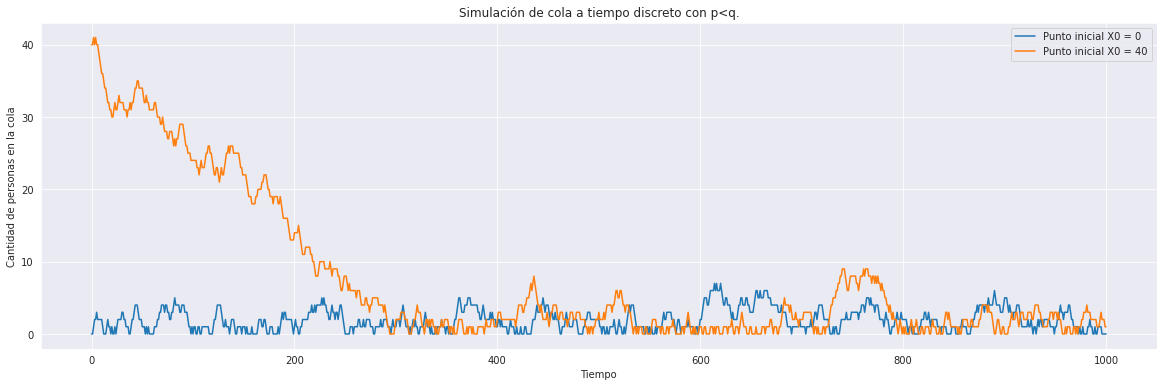

In [ ]:
p3=0.5
q3=0.6
N3=60
plt.figure(figsize=[20,6])
plt.plot(np.arange(0,n+1),cola(n,p3,q3,N3,0),label='Punto inicial X0 = 0')
plt.plot(np.arange(0,n+1),cola(n,p3,q3,N3,40),label='Punto inicial X0 = 40')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de personas en la cola')
plt.title('Simulación de cola a tiempo discreto con p<q.')
plt.legend()

En este caso, se puede observar que la cadena que parte en el punto $40$ tiende a decrecer hasta llegar a valores cercanos del $0$, y luego oscilar en las cercanías. Por su parte, la cadena que parte en $0$ tiende a concentrar su trayectoria en valores cercanos al $0$. Estos hechos se deben a que como $p<q$, es más probable que se vayan personas de la cola a que lleguen, por lo que con mayor la probabilidad la cadena irá tomando valores más bajos hasta llegar al $0$ (como se puede observar en la cadena con $x_0=40$), y luego como en $0$ no puede seguir decreciendo, tenderá a estabilizarse en los valores próximos a $0$ (como se puede observar en ambas cadenas), pudiendo crecer en algunos instantes, pero volviendo a decrecer rápidamente (con alta probabilidad).

Ahora notemos que al truncar la cadena hasta un $N$ tenemos que el espacio de estados es finito, con lo que tenemos que la cadena es recurrente positiva, y como es irreducible, tenemos la existencia de una probabilidad invariante $\pi^{N}$ para cualquier par $p,q\in(0,1).$

Para calcularla, tenemos las ecuaciones $\pi^{N}_{i}=\sum_{j=0}^{N}\pi^{N}_{j}p_{j,i}$ para $i=0,...,N,$ con lo que queda
\
\
$\pi^{N}_{0}=\pi^{N}_{0}\cdot p_{0,0}+\pi^{N}_{1}\cdot p_{1,0}=\pi^{N}_{0}(1-p)+\pi^{N}_{1}(1-p)q,$\
\
$\pi^{N}_{1}=\pi^{N}_{0}\cdot p_{0,1}+\pi^{N}_{1}\cdot p_{1,1}+\pi^{N}_{2}\cdot p_{2,1}=\pi^{N}_{0}p +\pi^{N}_{1}(pq+(1-q)(1-p))+\pi^{N}_{2}(1-p)q,$\
\
$\pi^{N}_{N}=\pi^{N}_{N}\cdot p_{N,N}+\pi^{N}_{N-1}\cdot p_{N-1,N}=\pi^{N}_{N}(1-q)+\pi^{N}_{N-1}(1-q)p,$\
\
$\pi^{N}_{N-1}=\pi^{N}_{N-2}\cdot p_{N-2,N-1}+\pi^{N}_{N-1}\cdot p_{N-1,N-1}+\pi^{N}_{N}\cdot p_{N,N-1}=\pi^{N}_{N-2}(1-q)p +\pi^{N}_{N-1}(pq+(1-q)(1-p))+\pi^{N}_{N}q$,\
\
$\pi^{N}_{i}=\pi^{N}_{i-1}\cdot p_{i-1,i}+\pi^{N}_{i}\cdot p_{i,i}+\pi^{N}_{i+1}\cdot p_{i+1,i}=\pi^{N}_{i-1}(1-q)p +\pi^{N}_{i}(pq+(1-q)(1-p))+\pi^{N}_{i+1}(1-p)q$ para $i=2,...,N-2.$

De la primera igualdad, sale que $\pi^{N}_{1}=\frac{p}{q(1-p)}\pi^{N}_{0}.$ De la segunda queda que $\pi^{N}_{2}=\pi^{N}_{1}\left(\frac{p(1-q)}{q(1-p)}+1\right)-\pi^{N}_{0}\frac{p}{q(1-p)}=\pi^{N}_{1}\frac{p(1-q)}{q(1-p)}.$

De la última igualdad, sale que $\pi^{N}_{i+1}=\pi^{N}_{i}\frac{1-(pq+(1-p)(1-q))}{q(1-p)}+\pi^{N}_{i-1}\frac{p(1-q)}{q(1-p)}=\pi^{N}_{i}\frac{p(1-q)+q(1-p)}{q(1-p)}+\pi^{N}_{i-1}\frac{p(1-q)}{q(1-p)}=\pi^{N}_{i}+(\pi^{N}_{i}-\pi^{N}_{i-1})\left(\frac{p(1-q)}{q(1-p)}\right),$ luego tenemos que $\pi^{N}_{i+1}-\pi^{N}_{i}=\left(\frac{p(1-q)}{q(1-p)}\right)(\pi^{N}_{i}-\pi^{N}_{i-1})$ para $i=2,...,N-2$, y con ello queda que $\pi^{N}_{i+1}-\pi^{N}_{i}=\left(\frac{p(1-q)}{q(1-p)}\right)^{i-1}(\pi^{N}_{2}-\pi^{N}_{1})$ para $i=2,...,N-2.$ Llamando $r=\frac{p(1-q)}{q(1-p)}$ tenemos que $\pi^{N}_{i+1}-\pi^{N}_{i}=r^{i-1}(\pi^{N}_{2}-\pi^{N}_{1})$ para $i=2,...,N-2$, luego sumando de $2$ hasta $k$, con $k\geq N-2$, tenemos que $\pi^{N}_{k+1}-\pi^{N}_{2}=\sum_{i=2}^{k}(\pi^{N}_{i+1}-\pi^{N}_{i})=(\pi^{N}_{2}-\pi^{N}_{1})\sum_{i=2}^{k}r^{i}=\pi^{N}_{1}(r-1)\left(\left(\sum_{i=0}^{k-1}r^{i}\right)-1\right)=\pi^{N}_{1}(r-1)\left(\frac{r^{k}-1}{r-1}-1\right)=\pi^{N}_{1}(r-1)\frac{r^{k}-r}{r-1}=r(r^{k-1}-1)\pi^{N}_{1}.$ Luego, $\pi^{N}_{k+1}=\pi^{N}_{2}+r(r^{k-1}-1)\pi^{N}_{1}=\pi^{N}_{1}\cdot r+r(r^{k-1}-1)\pi^{N}_{1}=r^{k}\pi^{N}_{1}=\frac{r^{k+1}}{1-q}\pi^{N}_{0}$ para $k=2,...,N-2.$ Así, $$\pi^{N}_{k}=\frac{r^{k}}{1-q}\pi^{N}_{0}$$ para $k=3,...,N-1$, pero notamos que esta fórmula calza con las encontradas para $\pi^{N}_{1}$ y $\pi^{N}_{2}$, por lo que $$\pi^{N}_{k}=\frac{r^{k}}{1-q}\pi^{N}_{0}$$ para $k=1,...,N-1.$

Finalmente, de la tercera igualdad, se obtiene que $\pi^{N}_{N}=\frac{p(1-q)}{q}\pi^{N}_{N-1}=r(1-p)\pi^{N}_{N-1}=\frac{1-p}{1-q}r^{N}\pi^{N}_{0}.$

Imponiendo que sea una distribución de probabilidad, tenemos que $$\sum_{i=0}^{N}\pi^{N}_{i}=\pi^{N}_{0}+\frac{\pi^{N}_{0}}{1-q}\sum_{i=1}^{N-1}r^{i} + \pi^{N}_{0}\frac{r^{N}(1-p)}{1-q}=1$$ tenemos que $$\pi^{N}_{0}=\left(1+\frac{1}{1-q}\sum_{i=1}^{N-1}r^{i} + \frac{r^{N}(1-p)}{1-q}\right)^{-1}.$$

Teniendo lo anterior, se utilizaron dos métodos que simulan cadenas de Markov para encontrar la distribución invariante $\pi^{N}$, en el caso $p<q.$

El primer método consiste en simular $K$ cadenas hasta tiempo $T$ (con $K$ y $T$ grandes), y luego calcular la medida empírica de las cadenas al tiempo $T$, es decir, calcular la frecuencia relativa de $X_{T}$ para las $K$ cadenas, y tiene su justificación en la convergencia al equilibrio de las cadenas de Markov irreducibles aperiódicas y recurrentes positivas.

El segundo método consiste en simular una cadena hasta un tiempo $T'$ (grande) y obtener las medias ergódicas $$\frac{1}{T}\sum_{k=1}^{T}\mathbb{1}_{X_{k}=i},$$ y tiene su justificación en el teorema ergódico visto en clases.

Así, para la simulación se consideró $p=0.8,q=0.81$, pues así la diferencia de ambos valores no es tan grande, y con ello, la cadena no tiende a quedar estancada en las cercanías del 0 tan rápidamente, permitiendo así estimar de mejor manera los valores de la distribución invariante. Además, se consideró como punto inicial a 0 y $N=27$, pues como se pudo observar en la parte anterior, la cadena cuando $p<q$ no suele crecer demasiado.

Se fijaron valores de $T,K$ y $T'$, de manera que en ambos métodos se utilizaran la misma cantidad de variables uniformes (se usan 2 en cada instante, una por cada variable Bernoulli), para así poder comparar la precisión de ambos bajo el mismo costo (de uniformes). Así, el valor máximo de $T'$ que se ocupó fue $1000000$ (se ocupan $2000000$ uniformes), mientras que se tomó $K=1000$ y $T=1000$ para así ocupar la misma cantidad de uniformes.

In [ ]:
p=0.8
q=0.81
N=27
K=1000
T=1000
T_=1000000
r=p*(1-q)/(q*(1-p))
pi_0=(1+sum(r**i for i in range(1,N))/(1-q)+r**N*(1-p)/(1-q))**(-1)
pi=np.zeros(N+1)
pi[0]=pi_0
for i in range(1,N+1):
    pi[i]=pi_0*r**i/(1-q)
pi[N]*=1-p

In [ ]:
#método medias empíricas
X=np.zeros((K,T+1))
X_T=np.zeros(K)
for k in range(K):
    X[k,:]=cola(T,p,q,N,0)
    X_T[k]=X[k,-1]

def medida_emp(X,N):
    return relfreq(X,N+1)[0]

#método medias ergódicas
X_=cola(T_,p,q,N,0)
def medias_erg(X,N):
    T_=len(X)
    return np.array([sum(np.where(X[1:]==i,1,0)) for i in range(0,N+1)])/T_

A continuación, se pueden apreciar gráficos obtenidos para las distribuciones empíricas por ambos métodos.

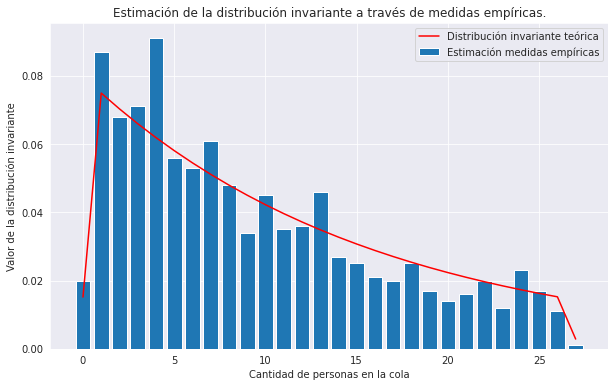

In [ ]:
plt.figure(figsize=[10,6])
plt.bar(np.arange(0,N+1),medida_emp(X_T,N),label='Estimación medidas empíricas')
plt.plot(pi,label='Distribución invariante teórica',color='r')
plt.xlabel('Cantidad de personas en la cola')
plt.ylabel('Valor de la distribución invariante')
plt.title('Estimación de la distribución invariante a través de medidas empíricas.')
plt.legend()

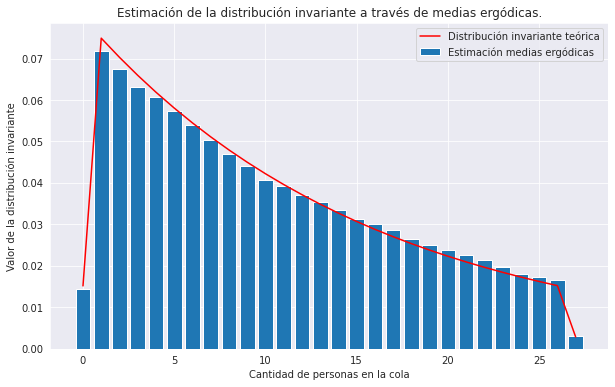

In [ ]:
plt.figure(figsize=[10,6])
plt.bar(np.arange(0,N+1),medias_erg(X_,N),label='Estimación medias ergódicas')
plt.plot(pi,label='Distribución invariante teórica',color='r')
plt.xlabel('Cantidad de personas en la cola')
plt.ylabel('Valor de la distribución invariante')
plt.title('Estimación de la distribución invariante a través de medias ergódicas.')
plt.legend()

Se puede observar que los valores estimados por el método de medias ergódicas parece estar mucho más ajustado a los valores reales de la distribución invariante. Para obtener datos más concretos, se comparó la precisión de ambas estimaciones a través de la distancia en variación total, la cual está dada por $$|\pi^{N}-\pi^{estimacion}|=\sum_{i=0}^{N}|\pi^{N}_{i}-\pi^{estimacion}_{i}|,$$ utilizando $20000,200000$ y $2000000$ uniformes (para el primer método, cuando se redujo el número de uniformes, se redujo el valor de $K$).


In [ ]:
def variacion_total(a,b):
    c=abs(a-b)
    return sum(c)

In [ ]:
VT_emp=np.zeros(3)
VT_erg=np.zeros(3)
for i in range(0,3):
    x=X[0:10**(i+1),-1]
    VT_emp[i]=variacion_total(medida_emp(x,N),pi)
    VT_erg[i]=variacion_total(medias_erg(X_[0:10**(i+4)],N),pi)

En la tabla a continuación se muestran los valores obtenidos al calcular la variación total entre la distribución invariante y las estimaciones según cada método, para los distintos números de variables uniformes utilizadas.

In [ ]:
variaciones=pd.DataFrame(data=np.transpose([np.array([20000,200000,2000000]),VT_emp,VT_erg]),columns=['Cantidad de uniformes','Variación total medidas empíricas','Variación total medias ergódicas'])
display(variaciones)

,Cantidad de uniformes,Variación total medidas empíricas,Variación total medias ergódicas
0,20000.0,1.417692,0.272770
1,200000.0,0.391087,0.072900
2,2000000.0,0.163542,0.032594


En los datos obtenidos, se ve reflejado que el método de medidas empíricas tiene una mayor variación total con la distribución invariante real que el método de medias ergódicas, para las 3 cantidades de uniformes consideradas. Con esto, se puede evidenciar que el método de medias ergódicas converge mucho más rápido al valor teórico de la distribución invariante, por lo que resulta en un método mucho más preciso y eficaz que el de medidas empíricas.